We now want to use the variables present in the data to perform predictive model on the movie sales.

# Data Extraction

In [1]:
# importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import calendar
warnings.filterwarnings("ignore")
sb.set()

# importing data
df = pd.read_csv("Highest Holywood Grossing Movies.csv").iloc[:,1:]

# removing null values
df2 = df[df['Release Date'].notna()]

# converting string to datetime
df2['Release Date'] = pd.to_datetime(df2['Release Date'], format='%B %d, %Y')

# extracting the information from the date
df2['Year'] = pd.DatetimeIndex(df2['Release Date']).year
df2['Quarter'] = pd.DatetimeIndex(df2['Release Date']).quarter
df2['Month'] = pd.DatetimeIndex(df2['Release Date']).month

# splitting the genres to different columns
genreList = pd.DataFrame(df2["Genre"].str.strip('[]').str.split(", ").explode().unique())[0].str.strip("''")
for genre in genreList:
    df2.loc[df2['Genre'].str.contains(genre), genre] = 1
    df2.loc[df2['Genre'].str.contains(genre)==False, genre] = 0
    
# converting the movie runtime into minutes
df2['Runtime (mins)'] = 0
df2['Runtime (mins)'] += df['Movie Runtime'].apply(lambda x: int(x.split(" hr")[0]))*60
df2.loc[df2['Movie Runtime'].str.contains('min'), 'Runtime (mins)'] += df.loc[df['Movie Runtime'].str.contains("min")]['Movie Runtime'].apply(lambda x: int(x.split("hr ")[1].split(" min")[0]))

# Building Machine Learning Models

In [2]:
# importing the necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [3]:
# displaying the column names
df2.columns

Index(['Title', 'Movie Info', 'Distributor', 'Release Date',
       'Domestic Sales (in $)', 'International Sales (in $)',
       'World Sales (in $)', 'Genre', 'Movie Runtime', 'License', 'Year',
       'Quarter', 'Month', 'Action', 'Adventure', 'Sci-Fi', 'Drama', 'Fantasy',
       'Romance', 'Animation', 'Family', 'Musical', 'Crime', 'Thriller',
       'Comedy', 'War', 'Biography', 'Mystery', 'Horror', 'Sport', 'Music',
       'History', 'Western', 'Documentary', 'Runtime (mins)'],
      dtype='object')

In [4]:
# keeping only numeric columns (or the columns encoded into binary values)
X = df2.drop(['Title', 'Movie Info', 'Distributor', 'Release Date', 'Domestic Sales (in $)', 'International Sales (in $)', 'World Sales (in $)', 'Genre', 'Movie Runtime', 'License'], axis=1)
X.dtypes

Year                int64
Quarter             int64
Month               int64
Action            float64
Adventure         float64
Sci-Fi            float64
Drama             float64
Fantasy           float64
Romance           float64
Animation         float64
Family            float64
Musical           float64
Crime             float64
Thriller          float64
Comedy            float64
War               float64
Biography         float64
Mystery           float64
Horror            float64
Sport             float64
Music             float64
History           float64
Western           float64
Documentary       float64
Runtime (mins)    float64
dtype: object

In [5]:
# choosing the world sales as the response variable
y = df2['World Sales (in $)']

In [6]:
# performing the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 21)

## Feature Importance using Random Forest

In [7]:
# Define a function to apply Random Forest model
def train_random_forest(n, m):
    # Create the Random Forest object
    rforest = RandomForestRegressor(n_estimators = n,  # n_estimators denote number of trees
                                     max_depth = m)       # set the maximum depth of each tree

    # Fit Random Forest on Train Data
    rforest.fit(X_train, y_train)

    # Predict Legendary values corresponding to Total
    y_train_pred = rforest.predict(X_train)
    y_test_pred = rforest.predict(X_test)

    return [r2_score(y_train_pred, y_train), r2_score(y_test_pred, y_test)]

In [8]:
# Iterations for different combination of n_estimators and max_depth
randomForestResult = []
nEstimators = list(range(10, 100+1, 10))
maxDepths = list(range(1, 15+1, 1))
for n in nEstimators:
    for m in maxDepths:
        randomForestResult.append(train_random_forest(n, m))

In [9]:
# store the scores into a dataframe
randForestResult = pd.DataFrame(columns=['n_estimators', 'max_depth', 'train_score', 'test_score'])
randomForestResultArray = np.array(randomForestResult)
i = 0
for n in nEstimators:
    for m in maxDepths:
        new_row = pd.DataFrame([[n, m, randomForestResultArray[i,0], randomForestResultArray[i,1]]], columns=randForestResult.columns)
        randForestResult = randForestResult.append(new_row, ignore_index = True)
        i += 1

In [ ]:
# Display the result of train score in heatmap
fig, ax = plt.subplots(figsize=(15,6))
heatmapDf = pd.pivot_table(randForestResult, index=['n_estimators'], columns=['max_depth'], values=['train_score'])
sb.heatmap(heatmapDf, annot=True, fmt='.3g', cmap='Blues')
ax.set_title('Train Score', fontsize = 20)
plt.show()

In [ ]:
# Display the result of test score in heatmap
fig, ax = plt.subplots(figsize=(15,6))
heatmapDf = pd.pivot_table(randForestResult, index=['n_estimators'], columns=['max_depth'], values=['test_score'])
sb.heatmap(heatmapDf, annot=True, fmt='.3g', cmap='Blues')
ax.set_title('Test Score', fontsize = 20)
plt.show()

We can see that the model performs quite poorly in the test set. We will however proceed to choose the one with the highest r2 score so far, which is n_estimators = 20 with max_depth = 12 where the r2 score = -0.11.

In [ ]:
rf = RandomForestRegressor(n_estimators=20, max_depth=12)
rf.fit(X_train, y_train)

In [ ]:
y_train_pred = rf.predict(X_train)
print(r2_score(y_train_pred, y_train))
y_test_pred = rf.predict(X_test)
print(r2_score(y_test_pred, y_test))

#### Feature importance based on mean decrease in impurity

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.show()

#### Feature importance based on feature permutation

In [ ]:
perm_importance = permutation_importance(rf, X_test, y_test)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

#### Feature importance based on SHAP values

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_test)

All three models agree that Adventure, Runtime (mins), and Year are one of the most important features in predicting the World Sales. We will now try to make use of these features to build our model.

## Building new models with selected predictors

In [ ]:
X2 = X[['Adventure', 'Runtime (mins)', 'Year']]
X2.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state = 30)

### Linear Regression

In [ ]:
#linear regression
lm = LinearRegression() #our 6th model
lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE train:", RMSE)
RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE test:", RMSE)
print()

print("R Square train:", r2_score(y_train, y_train_pred))
print("R Square test:", r2_score(y_test, y_test_pred))

### Random Forest

In [ ]:
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=20, max_depth=12)
rf.fit(X_train, y_train)

In [ ]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE train:", RMSE)
RMSE = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE test:", RMSE)
print()

print("R Square train:", r2_score(y_train, y_train_pred))
print("R Square test:", r2_score(y_test, y_test_pred))

### Gradient Boosting Regressor

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2.values, y.values, test_size = 0.3, random_state = 30)

In [ ]:
from sklearn import ensemble

params = {'n_estimators':50, 'max_depth':12, 'min_samples_split':2,
         'learning_rate':0.01, 'loss':'ls'}
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)
predictions2 = np.expand_dims(clf.predict(X_train), axis=1)
RMSE_train = np.sqrt(mean_squared_error(y_train, predictions2))
training_score = clf.score(X_train, y_train)

predictions2 = np.expand_dims(clf.predict(X_test), axis=1)
RMSE_test = np.sqrt(mean_squared_error(y_test, predictions2))
test_score = clf.score(X_test, y_test)

print("RMSE train:", RMSE_train)
print("RMSE test:", RMSE_test)
print()

print("R Square train:", training_score)
print("R Square test:", test_score)

We can see that Random Forest performs worst compared to the Linear Regression and Gradient Boost Regression. This might be caused the inability of Random Forest to extrapolate outside the train data set. We can see the plots below to illustrate this problem.

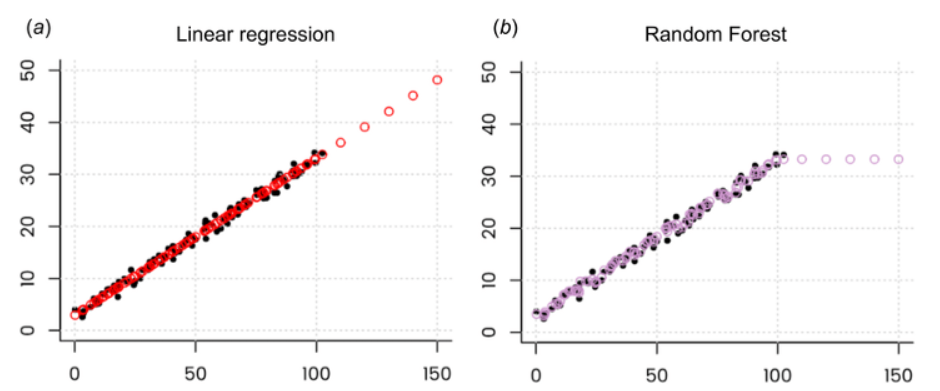

## Trying out different approach: convert World Sales into a binary variable

In this section, we will be using Neural Network to predict the goodness of the movie sales. The metric is such that:
- World sales is considered good (1) when it is larger than the median
- World sales is considered bad (0) when it is equal to or smaller than the median

### Using all numerical and encoded variables as predictors

In [ ]:
# check the data shape
limit = df2['World Sales (in $)'].median()
print(df2.loc[df2['World Sales (in $)']>limit].shape)
print(df2.loc[df2['World Sales (in $)']<=limit].shape)

We can see that the data is perfectly balanced for the two categories

In [ ]:
# creating the response variable
df2['Sales Goodness'] = 0
df2.loc[df2['World Sales (in $)']>limit, 'Sales Goodness'] = 1
df2.head()

In [ ]:
# keeping only numeric columns (or the columns encoded into binary values)
X = pd.DataFrame(df2.drop(['Title', 'Movie Info', 'Distributor', 'Release Date', 'Domestic Sales (in $)', 'International Sales (in $)', 'World Sales (in $)', 'Genre', 'Movie Runtime', 'License'], axis=1))
X.dtypes

# choosing the world sales as the response variable
y = pd.DataFrame(df2['Sales Goodness'])

# performing the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 32)

In [ ]:
# Check the sample sizes
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

In [ ]:
# Import the PyTorch essentials
import torch

# Convert the datasets to Tensors
X_train_tensor = torch.from_numpy(X_train.values).type(torch.float32)         # data type float
y_train_tensor = torch.from_numpy(y_train.values).type(torch.LongTensor)      # data type long
X_test_tensor = torch.from_numpy(X_test.values).type(torch.float32)           # data type float
y_test_tensor = torch.from_numpy(y_test.values).type(torch.LongTensor)        # data type long

# Check the tensor format of data
print("Tensor Predictor : \t", X_train_tensor.shape)
print("Tensor Response : \t", y_train_tensor.shape)

In [ ]:
# Define the layers
input_size = 26        # Dimension of Predictors
output_size = 2        # Dimension of Response

# Build a feed-forward network
neuralNet = torch.nn.Sequential(torch.nn.Linear(input_size, output_size),
                                torch.nn.LogSoftmax(dim = 1))

# Print the NeuralNet structure
print(neuralNet)
print()

# Print the NeuralNet parameters
list(neuralNet.parameters())

In [ ]:
# Set the Optimization Criterion
criterion = torch.nn.CrossEntropyLoss()

# Set the Optimization Technique
learning_rate = 0.01
optimizer = torch.optim.SGD(neuralNet.parameters(), lr = learning_rate)

In [ ]:
# Clear Optimizer Gradients
optimizer.zero_grad()
        
# Forward Propagation for Prediction
outputs = neuralNet(X_train_tensor)
print("Predictions\n", outputs)
print()

# Calculate the Loss
loss = criterion(outputs, y_train_tensor.squeeze())
print("Prediction Loss : \t", loss)

In [ ]:
# Check the Weights
print('Weights before Back Propagation')
print()
print(neuralNet[0].weight)
print()

# Back Propagation for Gradients
loss.backward()

In [ ]:
# Check the Gradients
print('Gradients from Back Propagation')
print()
print(neuralNet[0].weight.grad)
print()

In [ ]:
# Update Parameters by Gradients
optimizer.step()

# Check the Weights
print('Weights after Back Propagation')
print()
print(neuralNet[0].weight)

In [ ]:
# Forward Propagation for Prediction
outputs = neuralNet(X_train_tensor)
print("Predictions\n", outputs)
print()

# Calculate the Loss
loss = criterion(outputs, y_train_tensor.squeeze())
print("Prediction Loss : \t", loss)

In [ ]:
# Accuracy on Train Set
outputs = neuralNet(X_train_tensor)

# Find the maximum probability class
_, y_pred_train = torch.max(outputs, 1)

# Check if they match the actual class
correct = (y_pred_train == y_train_tensor.squeeze()).sum().item()
print("Classification Accuracy : \t", correct / len(y_train_tensor))

In [ ]:
# Accuracy on Test Set
outputs = neuralNet(X_test_tensor)

# Find the maximum probability class
_, y_pred_test = torch.max(outputs, 1)

# Check if they match the actual class
correct = (y_pred_test == y_test_tensor.squeeze()).sum().item()
print("Classification Accuracy : \t", correct / len(y_test_tensor))

### Train through iteration

In [ ]:
# Define the layers
input_size = 26      # Dimension of Predictors
output_size = 2        # Dimension of Response

# Build a feed-forward network
neuralNet = torch.nn.Sequential(torch.nn.Linear(input_size, output_size),
                                torch.nn.LogSoftmax(dim = 1))

# Print the NeuralNet structure
print(neuralNet)

In [ ]:
# Time the Training
import time
start = time.time()

# Set Hyperparameters
batch_size = 100
num_epochs = 20

# Set the Optimization Criterion
criterion = torch.nn.CrossEntropyLoss()

# Set Learning Parameter
learning_rate = 0.05


# Iterate for number of Epochs
for epoch in range(1, num_epochs + 1):
    
    # Create a new optimizer at the start of each epoch
    # Input the learning rate specified for this epoch
    optimizer = torch.optim.SGD(neuralNet.parameters(), lr = learning_rate)
    
    # Keep tab of accuracy
    running_loss = 0
    num_batches = 0
    correct = 0
    
    # Count the Number of Batches
    shuffled_indices = torch.randperm(len(X_train.index))
 
    for idx in range(0, len(X_train.index), batch_size):
        
        # Extract the data for the batch
        batch_indices = shuffled_indices[idx : idx + batch_size]
        X_batch_tensor = X_train_tensor[batch_indices]
        y_batch_tensor = y_train_tensor[batch_indices]
        
        # Clear Optimizer Gradients
        optimizer.zero_grad()

        # Forward Propagation for Prediction
        outputs = neuralNet(X_batch_tensor)

        # Calculate the Loss
        loss = criterion(outputs, y_batch_tensor.squeeze())
        
        # Calculate correct predictions
        _, y_pred_batch = torch.max(outputs, 1)
        correct += (y_pred_batch == y_batch_tensor.squeeze()).sum().item()

        # Back Propagation for Gradients
        loss.backward()

        # Update Parameters by Gradients
        optimizer.step()
        
        # Keeping tab of accuracy
        running_loss += loss.detach().item()
        num_batches += 1
    
    # At the end of an Epoch
    total_loss = running_loss / num_batches
    total_acc = correct / len(X_train.index)
    elapsed_time = time.time() - start
    
    print(f"Epoch {epoch:3.0f} : \t Loss = {total_loss:2.4f} \t Accuracy = {total_acc:2.4f} \t \t {elapsed_time:8.4f} seconds")

In [ ]:
# Accuracy on Train Set
outputs = neuralNet(X_train_tensor)

# Find the maximum probability class
_, y_pred_train = torch.max(outputs, 1)

# Check if they match the actual class
correct = (y_pred_train == y_train_tensor.squeeze()).sum().item()
print("Clasification Accuracy : \t", correct / len(y_train_tensor))

In [ ]:
# Accuracy on Test Set
outputs = neuralNet(X_test_tensor)

# Find the maximum probability class
_, y_pred_test = torch.max(outputs, 1)

# Check if they match the actual class
correct = (y_pred_test == y_test_tensor.squeeze()).sum().item()
print("Clasification Accuracy : \t", correct / len(y_test_tensor))

In [ ]:
# Define the layers
input_size = 26        # Dimension of Predictors
hidden_sizes = [32, 32]  # Dimension of Hidden Layers
output_size = 2          # Dimension of Response

# Build a feed-forward network
neuralNet = torch.nn.Sequential(torch.nn.Linear(input_size, hidden_sizes[0]),
                                torch.nn.ReLU(),
                                torch.nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                                torch.nn.ReLU(),
                                torch.nn.Linear(hidden_sizes[1], output_size),
                                torch.nn.LogSoftmax(dim=1))

# Print the NeuralNet structure
print(neuralNet)

In [ ]:
# Time the Training
import time
start = time.time()

# Set Hyperparameters
batch_size = 100
num_epochs = 100

# Set the Optimization Criterion
criterion = torch.nn.CrossEntropyLoss()

# Set Learning Parameter
learning_rate = 0.05


# Iterate for number of Epochs
for epoch in range(1, num_epochs + 1):
    
    # Decrease learning rate strategically
    if epoch % 10 == 0: 
        learning_rate = learning_rate / 1.5
        
    # Create a new optimizer at the start of each epoch
    # Input the learning rate specified for this epoch
    optimizer = torch.optim.SGD(neuralNet.parameters(), lr = learning_rate)
    
    # Keep tab of cumulative loss
    running_loss = 0
    num_batches = 0
    correct = 0
    
    # Count the Number of Batches
    shuffled_indices = torch.randperm(len(X_train.index))
 
    for idx in range(0, len(X_train.index), batch_size):
        
        # Extract the data for the batch
        batch_indices = shuffled_indices[idx : idx + batch_size]
        X_batch_tensor = X_train_tensor[batch_indices]
        y_batch_tensor = y_train_tensor[batch_indices]
        
        # Clear Optimizer Gradients
        optimizer.zero_grad()

        # Forward Propagation for Prediction
        outputs = neuralNet(X_batch_tensor)

        # Calculate the Loss
        loss = criterion(outputs, y_batch_tensor.squeeze())

        # Calculate correct predictions
        _, y_pred_batch = torch.max(outputs, 1)
        correct += (y_pred_batch == y_batch_tensor.squeeze()).sum().item()

        # Back Propagation for Gradients
        loss.backward()

        # Update Parameters by Gradients
        optimizer.step()
        
        # Keeping tab of cumulative loss
        running_loss += loss.detach().item()
        num_batches += 1
    
    # At the end of an Epoch
    total_loss = running_loss / num_batches
    total_acc = correct / len(X_train.index)
    elapsed_time = time.time() - start
    
    if epoch % 10 == 0: 
        print(f"Epoch {epoch:3.0f} : \t Loss = {total_loss:2.4f} \t Accuracy = {total_acc:2.4f} \t \t {elapsed_time:8.4f} seconds")    

In [ ]:
# Accuracy on Train Set
outputs = neuralNet(X_train_tensor)

# Find the maximum probability class
_, y_pred_train = torch.max(outputs, 1)

# Check if they match the actual class
correct = (y_pred_train == y_train_tensor.squeeze()).sum().item()
print("Clasification Accuracy : \t", correct / len(y_train_tensor))

In [ ]:
# Accuracy on Test Set
outputs = neuralNet(X_test_tensor)

# Find the maximum probability class
_, y_pred_test = torch.max(outputs, 1)

# Check if they match the actual class
correct = (y_pred_test == y_test_tensor.squeeze()).sum().item()
print("Clasification Accuracy : \t", correct / len(y_test_tensor))

We can see that the first Neural Network model performs best in general (for both train and test set) in comparison to the iterative Neural Network and Deeper Neural Network models. This might be caused by the overfitting in the second and the third model. Therefore, we will now try to use the first model to fit the selected predictors from the feature importance analysis obtained previously.

### Using ['Adventure', 'Runtime (mins)', 'Year'] as predictors

In [ ]:
# keeping only numeric columns (or the columns encoded into binary values)
X2 = X[['Adventure', 'Runtime (mins)', 'Year']]
X2.dtypes

# choosing the world sales as the response variable
y = pd.DataFrame(df2['Sales Goodness'])

# performing the train test split
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.25, random_state = 30)

In [ ]:
# Check the sample sizes
print("Train Set :", X_train.shape, y_train.shape)
print("Test Set  :", X_test.shape, y_test.shape)

In [ ]:
# Import the PyTorch essentials
import torch

# Convert the datasets to Tensors
X_train_tensor = torch.from_numpy(X_train.values).type(torch.float32)         # data type float
y_train_tensor = torch.from_numpy(y_train.values).type(torch.LongTensor)      # data type long
X_test_tensor = torch.from_numpy(X_test.values).type(torch.float32)           # data type float
y_test_tensor = torch.from_numpy(y_test.values).type(torch.LongTensor)        # data type long

# Check the tensor format of data
print("Tensor Predictor : \t", X_train_tensor.shape)
print("Tensor Response : \t", y_train_tensor.shape)

In [ ]:
# Define the layers
input_size = 3        # Dimension of Predictors
output_size = 2        # Dimension of Response

# Build a feed-forward network
neuralNet = torch.nn.Sequential(torch.nn.Linear(input_size, output_size),
                                torch.nn.LogSoftmax(dim = 1))

# Print the NeuralNet structure
print(neuralNet)
print()

# Print the NeuralNet parameters
list(neuralNet.parameters())

In [ ]:
# Set the Optimization Criterion
criterion = torch.nn.CrossEntropyLoss()

# Set the Optimization Technique
learning_rate = 0.01
optimizer = torch.optim.SGD(neuralNet.parameters(), lr = learning_rate)

In [ ]:
# Clear Optimizer Gradients
optimizer.zero_grad()
        
# Forward Propagation for Prediction
outputs = neuralNet(X_train_tensor)
print("Predictions\n", outputs)
print()

# Calculate the Loss
loss = criterion(outputs, y_train_tensor.squeeze())
print("Prediction Loss : \t", loss)

In [ ]:
# Check the Weights
print('Weights before Back Propagation')
print()
print(neuralNet[0].weight)
print()

# Back Propagation for Gradients
loss.backward()

In [ ]:
# Check the Gradients
print('Gradients from Back Propagation')
print()
print(neuralNet[0].weight.grad)
print()

In [ ]:
# Update Parameters by Gradients
optimizer.step()

# Check the Weights
print('Weights after Back Propagation')
print()
print(neuralNet[0].weight)

In [ ]:
# Forward Propagation for Prediction
outputs = neuralNet(X_train_tensor)
print("Predictions\n", outputs)
print()

# Calculate the Loss
loss = criterion(outputs, y_train_tensor.squeeze())
print("Prediction Loss : \t", loss)

In [ ]:
# Accuracy on Train Set
outputs = neuralNet(X_train_tensor)

# Find the maximum probability class
_, y_pred_train = torch.max(outputs, 1)

# Check if they match the actual class
correct = (y_pred_train == y_train_tensor.squeeze()).sum().item()
print("Classification Accuracy : \t", correct / len(y_train_tensor))

In [ ]:
# Accuracy on Test Set
outputs = neuralNet(X_test_tensor)

# Find the maximum probability class
_, y_pred_test = torch.max(outputs, 1)

# Check if they match the actual class
correct = (y_pred_test == y_test_tensor.squeeze()).sum().item()
print("Classification Accuracy : \t", correct / len(y_test_tensor))

We can see that both train set and test set achieved accuracy of 50%. This model is not too bad but not good either. However, it is obviously better that the previous regressor models done with linear regression, random forest, and gradient boosting. This might suggest that the model doesn't perform well with regressor models. This is one good finding if we want to construct a better model in the future. A better model on movie sales prediction might be achieved with a more suitable function fitting and better data engineering.

## Merging the data with the other dataset to get more variables

In [ ]:
ratingsDf = pd.read_csv('title.ratings.tsv', delimiter='\t')
basicsDf = pd.read_csv('title.basics.tsv', delimiter='\t')
imdb = pd.merge(basicsDf, ratingsDf, on='tconst')[['primaryTitle', 'originalTitle', 'averageRating']]
imdb.head()

In [ ]:
dfTemp = pd.merge(df, imdb, left_on='Title', right_on='primaryTitle', how='left')
dfTemp.isna().sum()

We can see that the number of null values is incredibly high. This might be caused of the different data sources and therefore the naming of the title (such as the punctuation) might be different. We will however continue to build our model to see if we can extract any useful insight from here.

In [ ]:
dfTemp = pd.merge(df, imdb, left_on='Title', right_on='primaryTitle')
dfTemp.head()

In [ ]:
ratings = pd.DataFrame(dfTemp['averageRating'])
sales = pd.DataFrame(dfTemp['World Sales (in $)'])

# split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(ratings, sales, test_size = 0.20, random_state = 5)

# perform Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# coefficients of the Linear Regression line
coef = linreg.coef_[0][0]
intercept = linreg.intercept_[0]
print("Coefficient:", coef)
print("Intercept:", intercept)

In [ ]:
plt.scatter(ratings, sales)
plt.xlabel("Average Ratings")
plt.ylabel("World Sales ($)")
plt.show()

In [ ]:
# predict World Sales corresponding to Movie Runtime
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Plot the regression line
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(X_train, y_train, label = 'Actual data')
axes[0].plot(X_train, y_train_pred, color = "red", label = 'Regression line')
axes[0].set_xlabel("Runtime (mins)")
axes[0].set_ylabel("World Sales ($)")
axes[0].title.set_text('Plot of Train Set')
axes[1].scatter(X_test, y_test)
axes[1].plot(X_test, y_test_pred, color = "red")
axes[1].set_xlabel("Runtime (mins)")
axes[1].set_ylabel("World Sales ($)")
axes[1].title.set_text('Plot of Test Set')
f.legend(loc='upper right')
plt.show()

In [ ]:
# check the goodness of the model fit on train set
print("Goodness of fit of the model on train set")
print("Explained Variance (R^2):", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE):", mean_squared_error(y_train, y_train_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("\n")

# calculate the accuracy of the model fit on test set
print("Prediction accuracy of the model on test set")
print("Explained Variance (R^2):", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, y_test_pred)))

As we expected, the model performs pretty badly for this dataset. We can argue that the main reason is due to the lack of the data points. Besides, it might also be caused that ratings is not actually a good predictor of the movie sales. A larger sample size is required to define the exact relationship between the two variables.

## Building different kind of models: predictive models of other variables using sales as predictors

In this section, we want to do something different from the previous prediction model. Instead of using the other variables as predictors to predict world sales, in this section we want to use the sales columns to predict other variables such as Genre, Lisence, and Distributor. Since these variables are categorical in nature, we will need to perform encoding on these variables first. The algorithms that we will be using are XGBoost and Random Forest. In the end, we will compare the results obtained from these two algorithms.

In [ ]:
# importing the required libraries
import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler,StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
# extracting the data of the distributors
x = pd.DataFrame(df['Distributor'])
xx=pd.DataFrame(x.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False))
xx

In [ ]:
# extracting the data of the genre
y = pd.DataFrame(df['Genre'])
yy=pd.DataFrame(y.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False))
yy.dtypes

In [ ]:
# extracting the data of the license
z = pd.DataFrame(df['License'])
zz=pd.DataFrame(z.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False))
zz

In [ ]:
# extracting the predictors (domestic and international sales)
df_final = pd.concat([df['Domestic Sales (in $)'], df['International Sales (in $)']],axis=1)
df_final

In [ ]:
# converting the data type of the object
df['Distributor'] = df['Distributor'].astype('category')
df['Distributor'].dtypes

In [ ]:
# encoding the distributor column
df['Distributor'] = df['Distributor'].cat.codes
df['Distributor'].head()

In [ ]:
# converting the data type of the object
df['Genre'] = df['Genre'].astype('category')
df['Genre'].dtypes

In [ ]:
# encoding the genre column
df['Genre'] = df['Genre'].cat.codes
df['Genre'].head()

In [ ]:
# converting the data type of the object
df['License'] = df['License'].astype('category')
df['License'].dtypes

In [ ]:
# encoding the license column
df['License'] = df['License'].cat.codes
df['License'].head()

### Predicting Distributors

####  XGBoost

In [ ]:
# encoding the sales columns
x= df_final
y=(df['Distributor'])
preprocessor=make_column_transformer(
    (OneHotEncoder(),['Domestic Sales (in $)']),
    (SimpleImputer(strategy='median'), [df_final])
)

In [ ]:
x.dtypes

In [ ]:
# performing transformation and scaling on the model predictors
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2,random_state=32)
scaler = MaxAbsScaler()
x5_train = scaler.fit_transform(x_train)
x5_test = scaler.transform(x_test)

In [ ]:
# fitting the model
xgbmodel = XGBRegressor(n_estimators=919, learning_rate=0.05, n_jobs=4)
xgbmodel.fit(x_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(x_test, y_test)],
             verbose=False)
xgbmodel.fit(x_train, y_train)
predictions=xgbmodel.predict(x_test)
mae=mean_absolute_error(predictions, y_test)

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
results=cross_val_score(xgbmodel,x,y, cv=kfold)

In [ ]:
# displaying the model accuracy
print("XGBRegressor Accuracy: %.2f%% (std: %.2f%%), Mean Absolute Error in Model %.2f" % (results.mean()*100, results.std()*100, mae))

#### Random Forest

In [ ]:
# fitting the model
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=900, random_state=0)
regressor.fit(x,np.ravel(y,order="c"))

y_pred = regressor.predict(x_test)

In [ ]:
# evaluating the model error
print("Random Forest Regressor's  Mean Absolute Error: " + str(mean_absolute_error(y_pred, y_test)))

### Predicting Genre

#### XGBoost

In [ ]:
x= df_final
y=(df['Genre'])
preprocessor=make_column_transformer(
    (OneHotEncoder(),['Domestic Sales (in $)']),
    (SimpleImputer(strategy='median'), [df_final])
)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2,random_state=32)
scaler = MaxAbsScaler()
x5_train = scaler.fit_transform(x_train)
x5_test = scaler.transform(x_test)

In [ ]:
xgbmodel = XGBRegressor(n_estimators=919, learning_rate=0.05, n_jobs=4)
xgbmodel.fit(x_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(x_test, y_test)],
             verbose=False)
xgbmodel.fit(x_train, y_train)
predictions=xgbmodel.predict(x_test)
mae=mean_absolute_error(predictions, y_test)

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
results=cross_val_score(xgbmodel,x,y, cv=kfold)

In [ ]:
print("XGBRegressor Accuracy: %.2f%% (std: %.2f%%), Mean Absolute Error in Model %.2f" % (results.mean()*100, results.std()*100, mae))

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=900, random_state=0)
regressor.fit(x,np.ravel(y,order="c"))

y_pred = regressor.predict(x_test)

In [ ]:
print("Random Forest Regressor's  Mean Absolute Error: " + str(mean_absolute_error(y_pred, y_test)))

### Predicting License

#### XGBoost

In [ ]:
x= df_final
y=(df['License'])
preprocessor=make_column_transformer(
    (OneHotEncoder(),['Domestic Sales (in $)']),
    (SimpleImputer(strategy='median'), [df_final])
)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2,random_state=32)
scaler = MaxAbsScaler()
x5_train = scaler.fit_transform(x_train)
x5_test = scaler.transform(x_test)

In [ ]:
xgbmodel = XGBRegressor(n_estimators=919, learning_rate=0.05, n_jobs=4)
xgbmodel.fit(x_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(x_test, y_test)],
             verbose=False)
xgbmodel.fit(x_train, y_train)
predictions=xgbmodel.predict(x_test)
mae=mean_absolute_error(predictions, y_test)

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
results=cross_val_score(xgbmodel,x,y, cv=kfold)

In [ ]:
print("XGBRegressor Accuracy: %.2f%% (std: %.2f%%), Mean Absolute Error in Model %.2f" % (results.mean()*100, results.std()*100, mae))

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=900, random_state=0)
regressor.fit(x,np.ravel(y,order="c"))

y_pred = regressor.predict(x_test)

In [ ]:
print("Random Forest Regressor's  Mean Absolute Error: " + str(mean_absolute_error(y_pred, y_test)))

These results don't suggest a positive outcome because the Xgboost algorithm relies on the relation between variables on gradient analysis. The outcome is not very good because in this dataset, the discrepancy among movies is very high; hence, it is expected that the gradient learning would not be close to a linear relation. However, this doesn't diminish the calculated outcome because it conveys the variable relation very precisely along with the mean error in the model to establish the level of credibility that this model accounts for.  

The results for the Random Forest analysis are more encouraging for 'Distributor' and 'License' variable because the mean error is very low (0.4, 2.75), suggesting a good model. Although, with 'Genre' the model is not good because it has a low range of values and a lot of missing values which contribute to the discrepancies present in the model. 